In [1]:
%matplotlib inline

from process_nwb import resample as rs
from process_nwb.wavelet_transform import wavelet_transform
import matplotlib.pyplot as plt
import numpy as np
import tdt

import warnings
warnings.simplefilter("ignore")


In [2]:
cd ~/Desktop/Raw_signal/process_nwb

[Errno 2] No such file or directory: '/Users/macproizzy/Desktop/Raw_signal/process_nwb'
/Users/macproizzy/Desktop/laminar_uecog_viz


# Plotting HG 

******

extract functionality from wavelet transform? 

In [3]:
data_directory = r'/Users/macproizzy/Desktop/Raw_Signal/RVG02_B01'

stream = 'Wave'
stim_delay = 0.25 #sec

tdt_data = tdt.read_block(data_directory)
fs = tdt_data['streams'][stream]['fs']

read from t=0s to t=93.8s


In [32]:
tdt_data.epocs.mark

name:	'mark'
onset:	array([25.3464576 , 26.34211328, 27.34211072, 28.34210816, 29.3421056 ,
       30.34210304, 31.34214144, 32.34213888, 33.34213632, 34.34213376,
       35.3421312 , 36.34212864, 37.34216704, 38.34216448, 39.34216192,
       40.34215936, 41.3421568 , 42.34215424, 43.34219264, 44.34219008,
       45.34218752, 46.34218496, 47.3421824 , 48.34217984, 49.34221824,
       50.34221568, 51.34221312, 52.34221056, 53.342208  , 54.34220544,
       55.34224384, 56.34224128, 57.34223872, 58.34223616, 59.3422336 ,
       60.34223104, 61.34222848, 62.34226688, 63.34226432, 64.34226176,
       65.3422592 , 66.34225664, 67.34225408, 68.34229248, 69.34228992,
       70.34228736, 71.3422848 , 72.34228224, 73.34227968, 74.34231808,
       75.34231552, 76.34231296, 77.3423104 , 78.34230784, 79.34230528,
       80.34234368, 81.34234112, 82.34233856, 83.342336  , 84.34233344])
offset:	array([26.34211328, 27.34211072, 28.34210816, 29.3421056 , 30.34210304,
       31.34214144, 32.34213888, 33

In [33]:
fs

12207.03125

In [34]:
93.8*fs #this is the number of timepoints 

1145019.53125

In [35]:
duration = 93.8

In [4]:
neural_data= (tdt_data.streams[stream].data[:])

In [37]:
#shape is 128 x 1144832(number of timepoints?) so we have 128 arrays with timepoints for each channel 
neural_data.shape

(128, 1144832)

In [5]:
right_shape = np.transpose(neural_data)

In [6]:
right_shape[:1000000].shape

(1000000, 128)

# This is where the script fails if the whole dataset is used

In [7]:


tf_data, _, ctr_freq, bw = wavelet_transform(right_shape[:750000], fs)

tf_data: time frequency data \
ctr_freq: center frequencies, also representative of the number of time frequency bands \
bw = bandwidth? 

In [8]:
t = np.linspace(0, 750000, 750000)

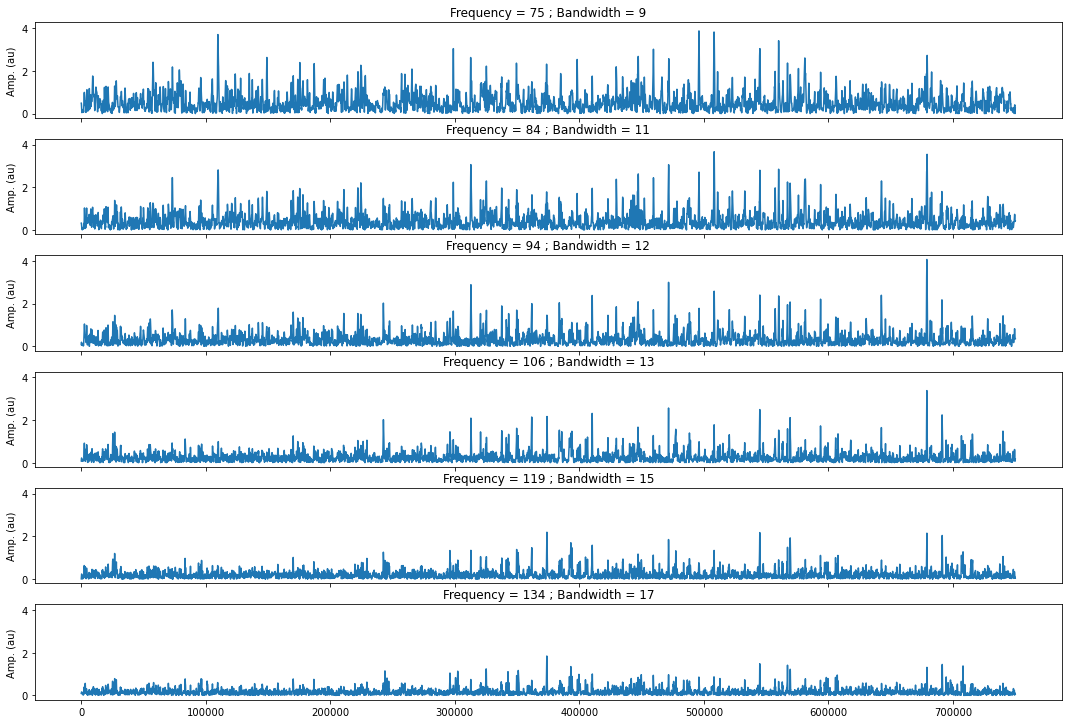

In [9]:
tf_data = abs(tf_data)

num_tf_signals = len(ctr_freq)
fig, axs = plt.subplots(num_tf_signals, 1, sharex=True, sharey=True, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4)
fig.tight_layout()


for idx in range(num_tf_signals):
    sig = tf_data[:, 1, idx]
    axs[idx].plot(t, sig)
    axs[idx].set_title('Frequency = {0:.0f} ; Bandwidth = {1:0.0f}'.format(ctr_freq[idx], bw[idx]))
    axs[idx].set_ylabel('Amp. (au)')


In [10]:
end_timepoint_baseline = int(fs*.25)

In [11]:
mean = tf_data[:end_timepoint_baseline].mean(axis=0, keepdims=True)
std = tf_data[:end_timepoint_baseline].std(axis=0, keepdims=True)
tf_norm_data = (tf_data - mean) / std
high_gamma = tf_norm_data.mean(axis=-1)


In [12]:
tf_norm_data.shape

(750000, 128, 6)

In [13]:
high_gamma.shape

(750000, 128)

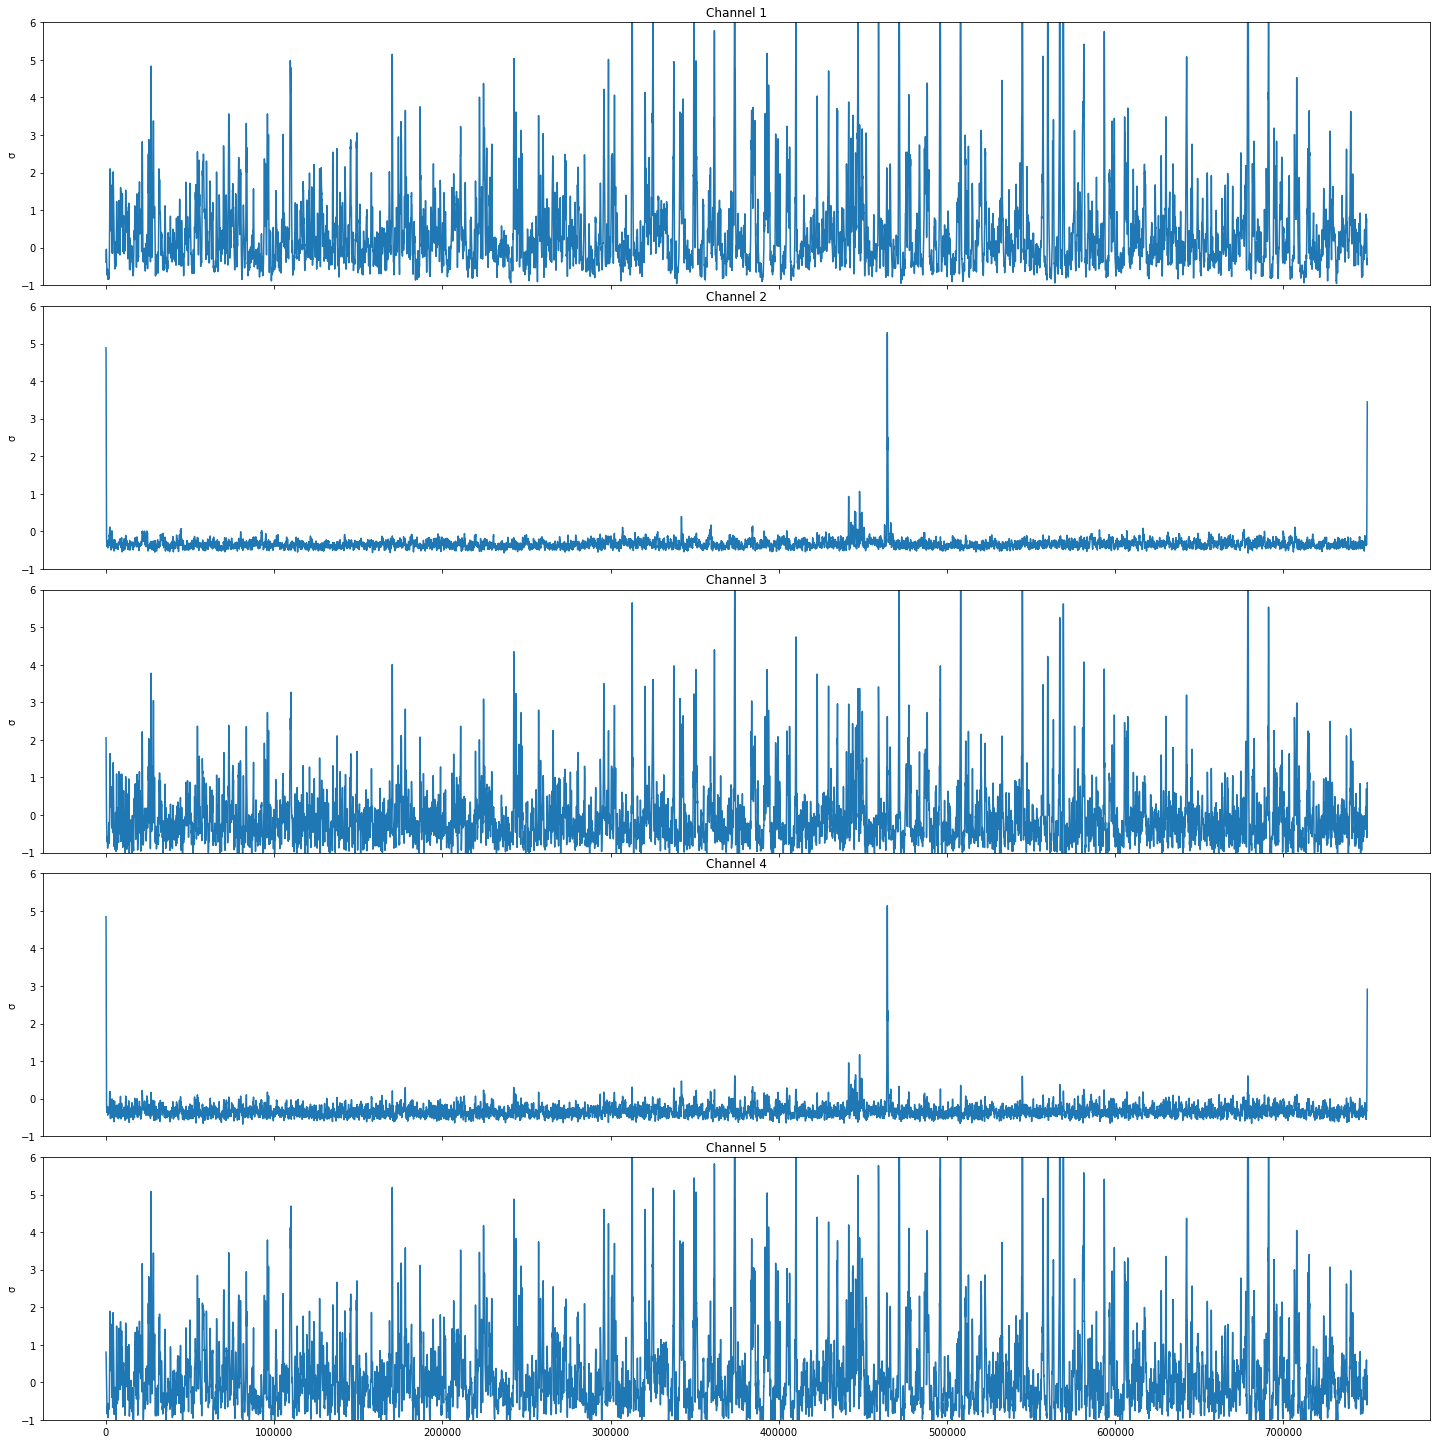

In [17]:
fig, axs = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(20, 20))
fig.subplots_adjust(hspace=0.4)
fig.tight_layout()

for idx in range(1,6):
    sig = high_gamma[:, idx]
    axs[idx-1].plot(t, sig)
    axs[idx-1].set_title('Channel {0:.0f}'.format(idx))
    axs[idx-1].set_ylabel('σ')
    axs[idx-1].set_ylim(-1, 6)

In [22]:
markers = tdt_data.epocs.mark.onset

In [24]:
markers_timepoints = markers*fs

In [34]:
first_trial_test_start = int(markers_timepoints[2] - 10000)
first_trial_test_end = int(markers_timepoints[2] + 10000)

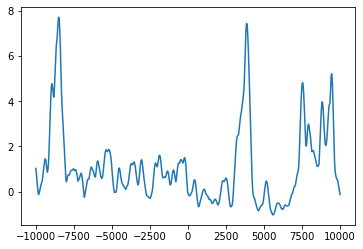

In [35]:
sig = high_gamma[first_trial_test_start:first_trial_test_end, 13]
plt.plot(np.linspace(-10000, 10000, 20000), sig)

# Trializing the Data 5/30

In [78]:
def get_trials_mat(signal, markers, pre_buf=10000, post_buf=10000):
    """Returns trial matrix
    Args:
        signal (np.array): Signal vector
        markers (list): List of trial onset in samples
        pre_buf (int, optional): Number of samples to pull prior to baseline. Defaults to 10000.
        post_buf (int, optional): Number of samples to pull after. Defaults to 10000.
    Returns:
        trials_mat (np.array): Trial matrix samples by trials
    """
    nsamples = post_buf + pre_buf
    ntrials = len(markers)
    trials_mat = np.empty((nsamples, ntrials))
        
    for idx, marker in enumerate(markers):
        start_frame, end_frame = marker - pre_buf, marker + post_buf
        trials_mat[:, idx] = signal[int(start_frame):int(end_frame)]
    return trials_mat

In [79]:
def zscore_data(tf_data, num_base_pts=200):
    """Compute zscore across trial matrix
    Args:
        tf_data (nparray): Trial matrix of samples x trials
        num_base_pts (int, optional): The first num_base_pts are used for baseline. Defaults to 200.
    Returns:
        tf_norm_data (nparray): Normalized trial matrix
    """
    # Zscore the data
    mean = tf_data[:num_base_pts].mean(axis=0, keepdims=True)
    std = tf_data[:num_base_pts].std(axis=0, keepdims=True)
    tf_norm_data = (tf_data - mean) / std    
    return tf_norm_data

In [96]:
def compute_hg(trials_mat, fs, pre_buf=1500, post_buf=1500, baseline=200):
    """Computes hg using wavelet transform
    Args:
        trials_mat (list): List of np-arrays that contain trial matrices (samples x trials)
        fs (numeric): Sample rate
        pre_buf (int, optional): The number of samples to include prior to sample midpoint of trials_mat. Defaults to 1500.
        post_buf (int, optional): The number of samples to include after the sample midpoint. Defaults to 1500.
        baseline (int, optiona): The first set of samples to include in baseline. Defaults to 200.
    Returns:
        Xnorm, f (nparray, nparray): Returns zscored wavelet magnitude coefficients and corresponding frequencies
    """
    Xh, _, f, _  = wavelet_transform(trials_mat, rate=fs)
    Xm = abs(Xh) #take abs value
    Xnorm = zscore_data(Xm, baseline) #zscore 
    return Xnorm, f

In [97]:
fs_stim_delay = 0.25 * fs

In [98]:
wave_data = tdt_data.streams.Wave.data
markers = tdt_data.epocs.mark.onset

#marker onsets: x*fs to get the data in timepoints, add the fs_stim_delay
marker_onsets = [int(x*fs+fs_stim_delay) for x in markers] 

In [99]:
wave_data = tdt_data.streams.Wave.data

In [100]:
wave_data.shape

(128, 1144832)

In [101]:
#transposing wave data, extracting one channel
new_wave_data = wave_data.T  # samples x channels
one_channel = new_wave_data[:,13]

In [102]:
trials_mat = get_trials_mat(one_channel, marker_onsets)

In [103]:
xnorm_hg, f = compute_hg(trials_mat, fs)

ValueError: not enough values to unpack (expected 4, got 2)

inspired by other nb


In [ ]:
data_directory_izzy = r'/Users/macproizzy/Desktop/Raw_Signal/RVG02_B01'